<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Utilities" data-toc-modified-id="Utilities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utilities</a></span><ul class="toc-item"><li><span><a href="#Bell-Curve-Random-Generator" data-toc-modified-id="Bell-Curve-Random-Generator-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Bell Curve Random Generator</a></span></li><li><span><a href="#Example-of-use-of-the-random-generator" data-toc-modified-id="Example-of-use-of-the-random-generator-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example of use of the random generator</a></span></li><li><span><a href="#Free-Speed-Generator" data-toc-modified-id="Free-Speed-Generator-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Free Speed Generator</a></span></li></ul></li><li><span><a href="#Entities" data-toc-modified-id="Entities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Entities</a></span><ul class="toc-item"><li><span><a href="#Lanes" data-toc-modified-id="Lanes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Lanes</a></span></li><li><span><a href="#Vehicles" data-toc-modified-id="Vehicles-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Vehicles</a></span><ul class="toc-item"><li><span><a href="#Property-Surround" data-toc-modified-id="Property-Surround-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Property Surround</a></span></li></ul></li></ul></li><li><span><a href="#Recorder" data-toc-modified-id="Recorder-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recorder</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulation</a></span></li><li><span><a href="#Multiple-Simulation-with-different-times-and-different--percentage-of-teslas" data-toc-modified-id="Multiple-Simulation-with-different-times-and-different--percentage-of-teslas-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Multiple Simulation with different times and different  percentage of teslas</a></span></li><li><span><a href="#Choice-of-the-best-combination-teslas/iat" data-toc-modified-id="Choice-of-the-best-combination-teslas/iat-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Choice of the best combination teslas/iat</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Frame-with-Traffic-Density-(veh/km)-and-Average-Speed-(km/h)-along-the-lane-segments" data-toc-modified-id="Frame-with-Traffic-Density-(veh/km)-and-Average-Speed-(km/h)-along-the-lane-segments-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Frame with Traffic Density (veh/km) and Average Speed (km/h) along the lane segments</a></span></li><li><span><a href="#Traffic-Flow-and-Travel-Times-in-s" data-toc-modified-id="Traffic-Flow-and-Travel-Times-in-s-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Traffic Flow and Travel Times in s</a></span></li><li><span><a href="#Traffic-Flow-in-veh/h" data-toc-modified-id="Traffic-Flow-in-veh/h-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Traffic Flow in veh/h</a></span></li><li><span><a href="#Traffic-volume-q,-total-number-of-vehicles-passing-per-hour-across-all-available-lanes" data-toc-modified-id="Traffic-volume-q,-total-number-of-vehicles-passing-per-hour-across-all-available-lanes-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Traffic volume q, total number of vehicles passing per hour across all available lanes</a></span></li><li><span><a href="#traffic-volum-at-the-exit-of-the-motorway" data-toc-modified-id="traffic-volum-at-the-exit-of-the-motorway-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>traffic volum at the exit of the motorway</a></span></li></ul></div>

<div style="background-color:rgba(0,0,255,0.4); padding:10px 10px;">
This version adds statistic support.
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random

import simpy

# Utilities

In [2]:
def isZero(x, ε = 0.00001):
    return abs(x)<ε

## Bell Curve Random Generator

In [3]:
gen_x_tab = None
gen_y_tab = None

def pdfv(x, mean=0, sd=None, delta=None):
    
    if sd is None and delta is None:
        sd = 1
    elif sd is None and delta is not None:
        sd = delta/math.sqrt(6)*0.9275
    
    τ = math.sqrt(6)
    x = (x-mean)/sd*0.9275
    return np.where(abs(x)<τ, 5/(8*τ*sd)*(1-x**2/2+x**4/24+1/2)*0.9275, 0)

def rv(mean=0, sd=None, delta=None, alternating=None, rounding=None):
    
    if sd is None and delta is None:
        sd = 1
    elif sd is None and delta is not None:
        sd = delta/math.sqrt(6)*0.9275

    global gen_count, gen_x_tab, gen_y_tab
    
    if gen_x_tab is None:
        
        # initialise global variables 
        gen_x_tab = list(np.linspace(-math.sqrt(6), -1.51, 500)) + \
                    list(np.linspace(-1.5, 0, 151)) 

        τ = math.sqrt(6)
        
        def cdf(x):
            return 5/(8*τ)*(x**5/120-x**3/6+x*3/2)+5/(8*τ)*(τ**5/120-τ**3/6+τ*3/2)
        
        gen_y_tab = [ cdf(x) for x in gen_x_tab ]
        
    y, sign = random.random(), 1
    if y>0.5:
        y, sign = 1-y, -1
    if alternating is not None:
        sign = 1 if alternating%2==0 else -1

    for i in range(1, len(gen_x_tab)):
        if y < gen_y_tab[i]:
            x0 = gen_x_tab[i]
            y0 = gen_y_tab[i]
            x1 = gen_x_tab[i-1]
            y1 = gen_y_tab[i-1]
            x = mean+sign*((x0+(y-y0)*(x1-x0)/(y1-y0))*sd/0.9275)
            if type(rounding) is int and rounding>0:
                return round(x, rounding)
            else:
                return x

## Example of use of the random generator

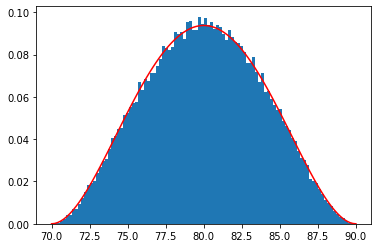

In [64]:
rv80 = [ rv(mean=80, delta=10) for i in range(100000) ]
_ = plt.hist(rv80, bins=100, density=True)

X = np.linspace(70, 90, 100)
Y = pdfv(X, mean=80, delta=10)
_ = plt.plot(X, Y, color='red')

## Free Speed Generator

In [5]:
free_speed_bins = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
free_speed_quantiles = np.cumsum([0, 0.006, 0.014, 0.052, 0.148, 0.27, 0.309, 0.143, 0.048, 0.01])

def free_speed_distribution():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(free_speed_quantiles)):
        if u<free_speed_quantiles[i+1]:
            p = (u-free_speed_quantiles[i])/(free_speed_quantiles[i+1]-free_speed_quantiles[i])
            return free_speed_bins[i]*p+free_speed_bins[i+1]*(1-p)
        
free_speed_data = [ free_speed_distribution() for i in range(1200)]
free_speed_kernel = stats.gaussian_kde(free_speed_data)

free_speeds = np.arange(30, 191)
free_speed_cdf = [ free_speed_kernel.integrate_box_1d(30, i) for i in free_speeds ]

def random_free_speed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(free_speeds)):
        if u<free_speed_cdf[i+1]:
            p = (u-free_speed_cdf[i])/(free_speed_cdf[i+1]-free_speed_cdf[i])
            return free_speeds[i]*p+free_speeds[i+1]*(1-p)

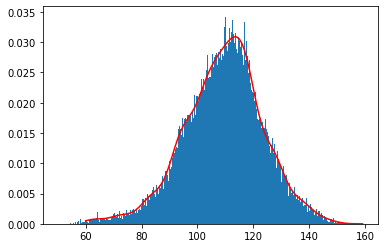

In [6]:
speeds = [ random_free_speed() for i in range(100000) ]
_ = plt.hist(speeds, bins=1000, density=True)
x = np.arange(60, 160, 1)
y = free_speed_kernel(x)
_ = plt.plot(x, y, color='red')

# Entities

## Lanes

[TOC](#Table-of-Contents) [Up](#Entities) [Next](#Vehicles)

The class `Lane` describes a segment of a lane. It has the width allowing only one vehicle at a point in the lane. i.e. there is no overtaking. Lane segments will be concatenated to form long stretches of road, and will be attached sidewise to each other to form multi lane infrastructure.

Lanes have a state consisting of the vehicles that are at a particular point in time on the lane segment. 

In [7]:
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

In [8]:
LANE_ID = 0

class Lane:
    
    def __init__(self, rec, length, speedLimit=None, merge=None):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
      
        self.rec = rec
        self.x0 = 0
        self.length = length
        
        # speed limit on this lane segment in km/h
        self.speedLimit = speedLimit 
        
        # indicates that at the end of the lance traffic has to merge to the left or right
        self.merge = merge 
        
        self.vehicles = []
        
        self.next = None
        self.prev = None
                
        # lane attached to the left/right
        self.left = None
        self.right = None
        
        rec.recordLane(self)
      
    # defines generic str() method for Lanes
    def __str__(self):
        l = " L:--" if self.left is None else f" L:{self.left.id:0>2d}"
        r = " R:--" if self.right is None else f" R:{self.right.id:0>2d}"
        s = "" if self.speedLimit is None else f" speedLimit:{self.speedLimit:d}km/h"
        return f"[{self.id:0>2d} x={self.x0:3.1f}m l={self.length:3.1f}m"+l+r+s+"]" + \
                    ("\\" if self.merge=='R' else "") + \
                    ("/" if self.merge=='L' else "") + \
                    ("-" + str(self.next) if self.next is not None else "")
    
    def getLane(self, direction):
        if direction=='slow':
            return self.left
        elif direction=='fast':
            return self.right
        else:
            return None

    ## additional code    
    # adding parallel lane on right side
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
        lane.x0 = self.x0
        lane.speedLimit = self.speedLimit
 
    ## additional code 
    # adding parallel lane on left side
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
        lane.x0 = self.x0
        lane.speedLimit = self.speedLimit
     
    ## additional code 
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenRight(self):
        lane = self
        newLane = Lane(self.rec, lane.length)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(self.rec, lane.length)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
    ## additional code 
    # constructs a number of lane segments of the same length
    # and attaches them to the left
    def widenLeft(self):
        lane = self
        newLane = Lane(self.rec, lane.length)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(self.rec, lane.length)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
            
    # defines concatenation of lanes
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.x0 = l.x0+l.length
        lane.prev = l
        return self
        
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    def between(self, posBack, posFront):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if posBack < v.pos and v.pos-v.length < posFront:
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if posFront > self.length and self.next is not None:
            return res + self.next.between(0, posFront-self.length)
        elif posBack < 0 and self.prev is not None:
            return self.prev.between(self.prev.length+posBack, self.prev.length) + res
        else:
            return res
        
    def inFront(self, pos, far):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far-(self.length-pos))

    def behind(self, pos, far):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lance
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far-pos)
        
    def enter(self, vehicle, pos=0, laneChange=False):
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane"+(f" {self.id:d}" if laneChange else ""))

    def leave(self, vehicle, laneChange=False):
        vehicle.rec.record(vehicle, event="leave lane"+(f" {self.id:d}" if laneChange else ""))
        vehicle.lane = None
        self.vehicles.remove(vehicle)

## Vehicles

[TOC](#Table-of-Contents) [Up](#Entities) [Prev](#Lanes) [Next](#Recorder)

The class Vehicle is introduced as clone of the class P.

In [9]:
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

In [10]:
VEHICLE_ID = 0

class Vehicle:
    def __init__(self, rec, 
                 startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 vmax=None, vmax_var=None,
                 t=[], v=[], vehicleType=''):
        
        global VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1
        
        
#####        
        if vehicleType=="FamilyCar":
            self.a_brake = -4.0 #[m/s²] 
            self.a_coast = -0.6 #[m/s²]
            self.a_max   =  2.5 #[m/s²] 
            self.length  =  4.2 # [m]
            self.vmax = vmax #[m/s]
            self.vmax_variation = 0.1
            self.absolute_speed_time_tolerance = 2 # [s]
            self.relative_speed_time_tolerance = 5 # [s]
            self.far_away_in_front = 200 # [m]
            self.far_away_in_back = 80 # [m]
            self.min_action_time = 0.5 # [s]  
            self.lane_change_time = 4 # [s] 
            self.min_speed_diff = 3 # [m/s]
        elif vehicleType=="Tesla":
            self.a_brake = -8.0 #[m/s²]
            self.a_coast = -1.8 #[m/s²]
            self.a_max   =  4.6 #[m/s²]
            self.length  =  4.6 # [m] 
            self.vmax = vmax
            self.vmax_variation = 0.1
            self.absolute_speed_time_tolerance = 1 # [s]
            self.relative_speed_time_tolerance = 4 # [s]
            self.far_away_in_front = 220 # [m]
            self.far_away_in_back = 100 # [m]
            self.min_action_time = 0.2 # [s]  
            self.lane_change_time = 3 # [s] 
            self.min_speed_diff = 2 # [m/s]
        elif vehicleType=="HGV":
            self.a_brake = -2.5 #[m/s²]
            self.a_coast = -1.3 #[m/s²]
            self.a_max   =  1.8 #[m/s²]
            self.length  =  15.0 # [m] 
            self.vmax = vmax # 25 mps= 90kph. According to Irish lows the velocity limit in Ireland for HGV in a motorway is 90 kph
            self.vmax_variation = 0.01 
            self.absolute_speed_time_tolerance = 5 # [s]
            self.relative_speed_time_tolerance = 8 # [s]
            self.far_away_in_front = 100 # [m]
            self.far_away_in_back = 70 # [m]
            self.min_action_time = 0.5 # [s]  
            self.lane_change_time = 10 # [s] 
            self.min_speed_diff = 1 # [m/s]
        else:
            raise ValueError("Unknown VehicleType: "+vehicleType)

#####       
        #########self.vmax_variation = vmax_var if vmax_var is not None else 0.05
        self.timing = 100 # [s]
        self.timing_variation = 0.30 
        
        self.env = rec.env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
        # speedLimit once recognised
        self.speedLimit = None
        
        ## second lane reference during changing of lanes
        self.oldLane = None
        
        self.alternator = 0
            
        self.t0 = t0
        self.x0 = x0    # [m] the reference point is on the front of the vehicle
                        # the body of the vehicle of the given length is behind.
        self.dx0 = dx0
        self.ddx0 = ddx0
        self.dddx0 = dddx0

        self.t_target = t
        self.v_target = v
        # while there is an adjustment of velocity in progress
        # the current_target is set
        self.current_target = None

        # trace flags
        self.traceAdjustVelocity = False
        self.traceInterrupt = False
        self.traceBraking = False
        self.traceCrash = False
        self.traceSurround = False
        self.traceOvertaking = False
 
        # start process
        self.running = False
        self.crashed = False
                
        # Flags used for temporarily exclusive behaviour
        self.laneChangeControl = False 
                # This flag is used to block automatic overtaking
                # while processing explicit lane change control
        self.braking = False
                # This flag is used to prevent interrupting braking for braking
        self.changingLane = False
                # This flag is used to prevent interrupting lanechanging
        
        self.processRef = None
        self.env.process(self.process())
    
    def trace(self, message):
        print(f"t={self.t0:7,.1f}s x={self.x0:7,.1f}m v{self.id:d}", message)
        
    def isNotFasterThan(self, other):
        return True if other is None else self.dx0 <= other.dx0
    
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    ## adapted to handle lane information
    def updateOnly(self):
        t = self.env.now
        if t < self.t0 or not self.running:
            return False
        if t > self.t0:
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx
            
            ## begin additional code
            self.pos = round(self.pos+Δx, 2)
            # update lane information if necessary
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.oldLane = None
                    self.rec.record(self, event='end')
                    self.running = False
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
            ## end additional code
            
        return True
        
    ## minor change only
    def update(self):
        
        self.surround = Surround(self)
        
        ## instead of direct link, call method
        inFront = self.surround.front
        
        # if there is a running or crashed vehicle in front and
        # we have crashed into the rear end of that vehicle
        if inFront is not None and inFront.x0-inFront.length < self.x0:
            self.crash(inFront)

        # if the speedLimit changes...
        elif self.speedLimit != self.lane.speedLimit:
            self.speedLimit = self.lane.speedLimit
            if self.speedLimit is None:
                # end of speed limit, return to default behaviour
                if self.vmax is not None and self.vmax>self.dx0:
                    Δt = max(self.min_action_time, (self.vmax-self.dx0)/self.a_max)
                    self.setTarget(Δt, self.vmax)
            else:
                vmax = self.speedLimit/3.6
                vmax = rv(mean=vmax, delta=self.vmax_variation*vmax)
                if vmax<self.dx0:
                    # when the new speedLimit is lower than current speed, coast down
                    Δt = max(self.min_action_time, (self.dx0-vmax)/self.a_coast)
                    self.setTarget(Δt, vmax)
                else:
                    # when the new speedLimit is higher than current speed, accelerate at half max a_max
                    Δt = max(self.min_action_time, 2*(vmax-self.dx0)/self.a_max)
                    self.setTarget(Δt, vmax)
                
        # if at the end of the lane merging is required      
        elif self.lane.merge is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane:
            if self.lane.merge == 'R':
                if self.surround.rightLane is not None and \
                        self.surround.right is None and \
                        self.isNotFasterThan(self.surround.rightFront) and \
                        self.isNotSlowerThan(self.surround.rightBack):
                    self.setTarget(self.lane_change_time, 'fast')
            elif self.lane.merge == 'L':
                if self.surround.leftLane is not None and \
                        self.surround.left is None and \
                        self.isNotFasterThan(self.surround.leftFront) and \
                        self.isNotSlowerThan(self.surround.leftBack):
                    self.setTarget(self.lane_change_time, 'slow')                
        
        # start overtaking maneuver by changing into fast lane
        elif inFront is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.dx0 > inFront.dx0 + self.min_speed_diff and \
                self.x0 + (self.lane_change_time+self.absolute_speed_time_tolerance)*self.dx0 > inFront.x0-inFront.length and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            self.setTarget(self.lane_change_time, 'fast')

        # if there is a vehicle in front 
        # which drives slower and
        # the distance to that vehicle in front is at current speed
        # less than the critical time tolerance of this driver
        elif inFront is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.dx0 > inFront.dx0 and \
                self.x0 + self.absolute_speed_time_tolerance*self.dx0 > inFront.x0:
            # note that self.a_coast is a negative acceleration
            Δt = max(self.min_action_time, (inFront.dx0-self.dx0)/self.a_coast)
            if self.current_target is None or \
                    not isZero(self.current_target-inFront.dx0):
                self.setTarget(Δt, inFront.dx0)

        # end overtaking by returning to slow lane
        elif self.surround.leftLane is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.surround.leftLane.totalLength()-self.pos>100 and \
                self.surround.left is None and \
                self.isNotSlowerThan(self.surround.leftBack) and \
                self.surround.leftFront is None:
            self.setTarget(self.lane_change_time, 'slow')
     
    ## code remains unchanged
    def setTarget(self, t, v):
        self.t_target = [ t ] + self.t_target
        self.v_target = [ v ] + self.v_target
        self.interruptProcess()
      
    ## minor change only
    def process(self):

        # delay start to the given time t-
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = self.env.now
        self.running = True
        self.rec.startRecording(self)
        
        ## begin additional code
        ## enter the first lane
        self.startingLane.enter(self)
        ## end additional code
        
        while self.updateOnly():

            ## instead of direct link, call method
            inFront = self.lane.inFront(self.pos, self.far_away_in_front) \
                        if self.lane is not None else None
                
            # if the car in front is slower and we are a bit too near on its heals...
            if inFront is not None and inFront.dx0 < self.dx0 and \
                    inFront.x0-inFront.length < \
                        self.x0 + self.relative_speed_time_tolerance*(self.dx0-inFront.dx0):
                yield from self.emergencyBraking(inFront.dx0)
                if not isZero(self.dx0-inFront.dx0):
                    # after emergency breaking adjust to the speed of the car in front...
                    Δt = 1
                    self.setTarget(Δt, inFront.dx0)
                continue 
                    
            if len(self.t_target)>0:
                
                t_target = self.t_target[0]
                v_target = self.v_target[0]
                self.t_target = self.t_target[1:]
                self.v_target = self.v_target[1:]
                
                if type(v_target) is str:
                    
                    # explicit overtake commands temporarily
                    # disable overtaking
                    if v_target=='R':
                        self.laneChangeControl = True
                    elif v_target=='L':
                        self.laneChangeControl = False
                        
                    direction = normaliseDirection(v_target)
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(inFront, direction, t_target)
                
                ## the rest is what was there before
                else:
                    v0 = self.dx0
                    v1 = v_target
                    Δt = t_target
                    if isZero(v1-v0):
                        yield from self.continueAtSameSpeed(Δt)
                    else:
                        yield from self.adjustVelocity(v1-v0, Δt)
                    
            ## additional code
            elif self.vmax is not None:
                
                # if the explicit control strategy is exhausted and
                # a target maximum speed is set the vehicle will follow
                # a random speed around the target maximum speed

                ## additional code
                vmax = self.vmax
                if self.speedLimit is not None:
                    vmax = self.speedLimit/3.6
                    vmax = rv(mean=vmax, delta=self.vmax_variation*vmax)
                    
                # as long there is no vehicle in front or the vehicle in front
                # is far enough ahead
                if inFront is None or \
                    self.x0 + self.relative_speed_time_tolerance*(self.dx0-inFront.dx0) < inFront.x0:
                    v0 = self.dx0
                    self.alternator += 1
                    v1 = rv(mean=vmax, 
                            delta=self.vmax_variation*vmax, 
                            alternating=self.alternator,
                            rounding=2)
                    Δt = rv(mean=self.timing, 
                            delta=self.timing*self.timing_variation,
                            rounding=1)
                
                    yield from self.adjustVelocity(v1-v0, Δt)
                else:
                    yield from self.continueAtSameSpeed(10)
            else:
                yield from self.continueAtSameSpeed(10)
                
        self.rec.stopRecording(self)

    def crash(self, other):
        
        def recordCrash(v):
            v.rec.record(v, 'crash')
            v.running = False
            v.crashed = True
            # stop anything your are currently doing...
            v.interruptProcess()
            v.dx0 = 0
            v.ddx0 = 0
            v.dddx0 = 0
            
        if self.running:
            if self.traceCrash:
                self.trace(f"Crashed into v{other.id:d} at x={self.x0:7.1f}m")
            recordCrash(self)
            if other.running:
                recordCrash(other)
        
    def emergencyBraking(self, v):
        
        def emergencyBrakingProcess(v):
            
            if self.traceBraking:
                self.trace(f"Braking from v={self.dx0:4.1f}m/s to {v:4.1f}m/s")
           
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_brake-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_brake
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
            self.rec.record(self, 'brake end')
            
            if self.traceBraking:
                self.trace(f"Braking end  v={self.dx0:4.1f}m/s")

        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            if self.traceInterrupt or self.traceBraking:
                self.trace(f"Braking interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.processRef = None
        self.braking = False
        
    def changeLane(self, inFront, direction, Δt):
     
        def changeLaneProcess(oldLane, newlane, Δt, trace=True):
            # self.updateOnly()
            if trace and self.traceOvertaking and inFront is not None and  direction=='fast':
                other = f"v{inFront.id:d} " if inFront is not None else ""
                self.trace(f"Overtaking {other:s} at x={self.x0:7,.1f}m")
                
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos, laneChange=True) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            
            self.updateOnly()
            if not self.running:
                return
            currentLane = self.lane
            self.oldLane.leave(self, laneChange=True)
            self.lane = currentLane
            self.oldLane = None
            self.ddx0 = 0
            self.dddx0 = 0
            self.rec.record(self, 'done change '+direction)
            
            if trace and self.traceOvertaking and direction=='slow':
                self.trace(f"Overtaking done return to slow lane at x={self.x0:7,.1f}m")
            # self.updateOnly()
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        self.changingLane = True
        self.updateOnly()
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            if self.traceInterrupt and self.traceOvertaking:
                self.trace(f"Overtaking interrupted at x={self.x0:7,.1f}m")
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.updateOnly()
            # it is possible that there was an intermittent change lane event
            while self.lane != newLane and newLane is not None:
                newLane = newLane.next
                oldLane = oldLane.next
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4, trace=False))
        self.changingLane = False    
        
    # smoothly adjust velocity by Δv over the time Δt
    def adjustVelocity(self, Δv, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            
            self.updateOnly()
            
            if self.traceAdjustVelocity:
                self.trace(f"Adjusting Velocity from v={self.dx0:4,.1f}m/s by Δv={Δv:4,.1f}m/s over {Δt:4,.1f}s")
            
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt   
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
        
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
                    
            if self.traceAdjustVelocity:
                self.trace(f"Adjusted  Velocity to   v={self.dx0:4,.1f}m/s")
        
        # start process
        self.current_target = self.dx0 + Δv
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            # wait for the process to finish
            yield self.processRef
        except simpy.Interrupt:
            # in case this has been interrupted
            if self.traceInterrupt:
                self.trace(f"Adjusting Velocity interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.current_target = None
        self.processRef = None

    def continueAtSameSpeed(self, Δt):
        
        def continueAtSameSpeedProcess():
            # don't change the current velocity
            self.dddx0 = 0
            self.ddx0 = 0
            yield self.env.timeout(Δt)
        
        # start process
        self.processRef = self.env.process(continueAtSameSpeedProcess())
        try:
            # wait for the process to finish
            yield self.processRef
        except simpy.Interrupt:
            # in case this has been interrupted
            if self.traceInterrupt:
                self.trace(f"Constant Velocity interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('There are more important things to do...')

### Property Surround

The Surround of a vehicle is a data structure that joins a number of properties and gives access to the next vehicles to the front, back, left and right side of the vehicle.

* `leftLane` and `rightLane` are references to next `Lane` and are `None` is there is no lane to the left or right. 
* `left` and `right` are Boolean values that indicate that there is a vehicle in the critical region or not.
* `front` (`leftFront`, `rightFront`) and `back` (`leftBack`, `rightBack`) are references to the `Vehicle` in the indicated region that is next to the current position. If there is no such vehicle, the references return `None`.
* The limits of the relevant regions are defined based on the current position +/- a number of car lengths +/- a distance that is a multiple of the current velocity, defined as time constants.

<img src='Surround.png' width=600/>

In [11]:
class Surround:
    
    def __init__(self, vehicle):
        
        # For each of the directions None means that there is no 
        # vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected
        # if something goes wrong
        
        self.vehicle = vehicle
            
        self.leftBack = None
        self.left = None
        self.leftFront = None
        self.back = None

        self.front = None
        self.rightBack = None
        self.right = None
        self.rightFront = None
        
        lane = vehicle.lane
        posFront = vehicle.pos
        posBack = vehicle.pos-vehicle.length
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(posFront, self.vehicle.far_away_in_front)
            self.back = lane.behind(posBack, self.vehicle.far_away_in_back)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(posFront, self.vehicle.far_away_in_front)
                    self.rightBack = self.rightLane.behind(posBack, self.vehicle.far_away_in_back)
                else:
                    right = self.rightLane.between(posBack-10, posFront+10)
                    if len(right)==0:
                        # self.right = None
                        self.rightFront = self.rightLane.inFront(posFront+10, self.vehicle.far_away_in_front)
                        self.rightBack = self.rightLane.behind(posBack-10, self.vehicle.far_away_in_back)
                    else:
                        self.right = right[0]
                        # self.rightFront = None
                        # self.rightBack = None

            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(posFront, self.vehicle.far_away_in_front)
                    self.leftBack = self.leftLane.behind(posBack, self.vehicle.far_away_in_back)
                else:
                    left = self.leftLane.between(posBack-10, posFront+10)
                    if len(left)==0:
                        # self.left = None
                        self.leftFront = self.leftLane.inFront(posFront+10, self.vehicle.far_away_in_front)
                        self.leftBack = self.leftLane.behind(posBack-10, self.vehicle.far_away_in_back)
                    else:
                        self.left = left[0]
                        # self.leftFront = None
                        # self.lefttBack = None
                    
        if vehicle.traceSurround:
            
            def s(vehicle):
                if vehicle is None:
                    return " "
                elif type(vehicle) is list:
                    if len(vehicle)==1:
                        return s(vehicle[0])
                    else:
                        res = "["
                        for v in vehicle:
                            if len(res)>1:
                                res += ','
                            res+=s(v)
                        res += "]"
                        return res
                else:
                    return f"{vehicle.id:d}"

            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

# Recorder

[TOC](#Table-of-Contents)

In [12]:
class Recorder:
    
    def __init__(self, startTime=0, stopTime=0, timeStep=1):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = simpy.Environment()
        self.ps = []
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id', 'lane', 'oldLane', 'pos', 'event'])

    # runs the simulation
    def run(self):
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
    
    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()     
            yield self.env.timeout(self.timeStep)
            
    def startRecording(self, p):
        self.ps.append(p)
        self.record(p, event='start')
        
    def stopRecording(self, p):
        self.ps.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly() or event!='timer':
                laneId = -1 if p.lane is None else p.lane.id
                oldLaneId = -1 if p.oldLane is None else p.oldLane.id
                ix = len(self.data)
                self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, \
                                   laneId, oldLaneId, p.pos, event]
                if event=='timer':
                    p.update()
        else:
            for p in self.ps:
                self.record(p, event)

    ## additional code: record lane information
    def recordLane(self, lane):
        ix = len(self.data)
        self.data.loc[ix]=[0, 0, 0, 0, 0, lane.id, -1, lane.length, 'lane info'] 

    ## additional code: record lane information
    def getLaneLength(self, laneId):
        lanes = self.data[self.data.event=='lane info']
        lane = lanes[lanes.lane==laneId]
        return lane.pos.iloc[0]
    
    def saveData(self, filename):
        self.data.to_csv(filename, index=False)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)
    
    ## new code: computes traffic flow in vehicles/h at the end of a given lane
    ## based on 'leave lane' events proper (i.e. excluding overtaking)
    def flow(self, lane):
        df = self.data[self.data.event=='leave lane']
        df = df[df.lane==lane]
        if len(df)>1:
            # compensate for lane filling late or early running dry
            f = (len(df)-1)*3600/(df.t.max()-df.t.min())
            return round(f, 2)
        else:
            return 0

    ## new code: computes the average travelling time through a lane segment
    def avgTravelTime(self, laneId):
        d0 = self.data[self.data.event=='enter lane']
        d0 = d0[d0.lane==laneId]
        d1 = self.data[self.data.event=='leave lane']
        d1 = d1[d1.lane==laneId]
        times = []
        id0 = d0.id.unique()
        id1 = d1.id.unique()
        for id in id0:
            t0 = d0.t[d0.id==id].min()
            if id in id1:
                t1 = d1.t[d1.id==id].max()
                times += [ t1-t0 ]
        avg = 0
        if len(times)>0:
            avg = round(sum(times)/len(times), 2)
        return avg

    def avgSpeed(self, laneId):
        return round(3.6*self.getLaneLength(laneId)/self.avgTravelTime(laneId),2)
        
        
    ## new code: computes traffic density in vehicles/km for a given lane
    ## at a given moment in time. When no time is specified it returns a
    ## list of traffic densities over time.
    def density(self, laneId, time=None):
        timerEvents = self.data[self.data.event=='timer']
        times = timerEvents.t.unique()
        laneEvents = timerEvents[timerEvents.lane==laneId]
        laneLength = self.getLaneLength(laneId)
        
        if time is None:
            densities = []
            for t in times:
                events = laneEvents[laneEvents.t==t]
                d = len(events)*1000/laneLength
                densities.append(round(d,2))
            return sum(densities)/len(densities)
        
        # find the timestamp nearest to the requested time
        if time in times:
            t = time
        else:
            # take the nearest point in time
            diff = list((times-time)**2)
            t = times[diff.index(min(diff))]
        events = laneEvents[laneEvents.t==t]
        d = len(events)*1000/laneLength
        return round(d,2)
    
    def plot(self, x, y, 
             vehicles=None, style='', lw=1, decoration=True,
             x0=None, x1=None, y0=None, y1=None, fillColor=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(5, 3), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, style, lw=lw, data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            if not decoration:
                continue
            
            # use small red circle to indicate emergency braking
            dc = df[df.event=='brake']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')
                            
            db = df[df.event=='brake end']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], marker='o', mec='r', fillstyle='none')

            # use black 'x' as crash indicator
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
                
            # use black Diamond to indicate that
            # a vehicle ran out of track
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
            # use black right pointing full triangle
            # to indicate that a vehicle started
            #  changing into the fast lane
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # use black right pointing hollow triangle
            # to indicate that a vehicle has finished
            # changing into the fast lane
            dc = df[df.event=='done change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], marker='>', mec='k', fillstyle='none')

            # use black left pointing full triangle
            # to indicate that a vehicle started
            #  changing into the slow lane
            dc = df[df.event=='change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # use black left pointing hollow triangle
            # to indicate that a vehicle has finished
            # changing into the slow lane
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], marker='<', mec='k', fillstyle='none')
            
        # fill area with background color
        if fillColor is not None:
            if x0 is None:
                x0=self.data[x].min()
            if x1 is None:
                x1=self.data[x].max()
            if y0 is None:
                y0=self.data[y].min()
            if y1 is None:
                y1=self.data[y].max()
            plt.fill_between( [x0, x1], [y0, y0], [y1, y1], color=fillColor)
            
        plt.grid(True)

# Simulation

In [13]:
def simulation(N, IAT, percOfTesla, printMotorway):
    VMAX = 120/3.6
    VMAXHGV=90/3.6
    random.seed(2)

    rec = Recorder(0, 200, 1)
    iat = [ rv(IAT, delta=0.4*IAT) for i in range(N) ]
    t = 0
    
#motorway constructioin
    l = Lane(rec, 1700)
    mergeLane = Lane(rec, 300, merge='R', speedLimit=120 )
    c= l.widenRight() 
    c1 = Lane(rec, 300) 
    mergeLane.attachRight(c1)
    c1.left = None  # don't move from the left lane onto the merge lane
    l.extend(mergeLane)
    c.extend(c1)
    c.extend(Lane(rec, 1000))
    r = c.widenRight()
    
    if printMotorway=='y':
        print("Left Lane:  ", l)
        print("Centre Lane:", c)
        print("Right Lane: ", r)

# distribute the vehicles among the 3 lanes:
    for i in range(N):
        u = random.random()
        t += iat[i]
        if u<0.33:
            num =l 
        elif u<0.66:
            num=c
        else:
            num=r
# end of distribution of veh among the 3 lanes

# selection of different vehicle type:

        u = random.random()
        if u<=percOfTesla:
            v = Vehicle(rec,startingLane=num, t0=t, dx0=VMAX, vmax=VMAX, vehicleType='Tesla')
        elif u<=(percOfTesla+0.15):
            v = Vehicle(rec,startingLane=num, t0=t, dx0=VMAXHGV, vmax=VMAXHGV, vehicleType='HGV')
        else:
            v = Vehicle(rec,startingLane=num, t0=t, dx0=VMAX, vmax=VMAX, vehicleType='FamilyCar')

#STEFANO TEMPORARY SET TO FALSE TO SHRINK OUTPUT. PLEASE SET TO True TO TRACE EVENTS
        v.traceCrash = False
        v.traceOvertaking = False
        v.traceInterrupt = False

        
    rec.run()
    #return rec.flow(2)+rec.flow(5)
    return rec

# Multiple Simulation with different times and different  percentage of teslas 

The following code runs the simulation for 11 different iat from 0.04 to 1.97 seconds and for different percentages of teslas specified in the variable teslas

Please notice that it takes around 15 minutes for an average pc to run this multiple simulation. Please scroll down to see the result shown in the picture 

In [14]:
df=[]

times= 0.04,0.05,0.06,0.09,0.14,0.21,0.33,0.52,0.81,1.26,1.97
teslas= 0,1,2,4,6,8,10,50,100

for i in range (len(times)):
    interAT = times[i]
    row=[]
    for j in range (len(teslas)):
        percOfTesla = teslas[j]
        dfrec = simulation(20, interAT, percOfTesla, 'n')
        crashes= len(dfrec.data[(dfrec.data['event']=='crash')])
        row.append(crashes)
        print('---IAT=',interAT,'Percent of Tesla %=',percOfTesla, 'Crashes=', crashes)
    df.append(row)
df = pd.DataFrame(df)

---IAT= 0.04 Percent of Tesla %= 0 Crashes= 18
---IAT= 0.04 Percent of Tesla %= 1 Crashes= 18
---IAT= 0.04 Percent of Tesla %= 2 Crashes= 18
---IAT= 0.04 Percent of Tesla %= 4 Crashes= 18
---IAT= 0.04 Percent of Tesla %= 6 Crashes= 18
---IAT= 0.04 Percent of Tesla %= 8 Crashes= 18
---IAT= 0.04 Percent of Tesla %= 10 Crashes= 18
---IAT= 0.04 Percent of Tesla %= 50 Crashes= 18
---IAT= 0.04 Percent of Tesla %= 100 Crashes= 18
---IAT= 0.05 Percent of Tesla %= 0 Crashes= 19
---IAT= 0.05 Percent of Tesla %= 1 Crashes= 18
---IAT= 0.05 Percent of Tesla %= 2 Crashes= 18
---IAT= 0.05 Percent of Tesla %= 4 Crashes= 18
---IAT= 0.05 Percent of Tesla %= 6 Crashes= 18
---IAT= 0.05 Percent of Tesla %= 8 Crashes= 18
---IAT= 0.05 Percent of Tesla %= 10 Crashes= 18
---IAT= 0.05 Percent of Tesla %= 50 Crashes= 18
---IAT= 0.05 Percent of Tesla %= 100 Crashes= 18
---IAT= 0.06 Percent of Tesla %= 0 Crashes= 19
---IAT= 0.06 Percent of Tesla %= 1 Crashes= 18
---IAT= 0.06 Percent of Tesla %= 2 Crashes= 18
---IA

In [43]:
file=df

In [44]:
teslasperc = ['0','1','2','4','6','8','10','50','100']

In [45]:
file2 = pd.DataFrame(file, columns=pd.Index(teslasperc, name='% Teslas / IAT'))

In [46]:
file2

% Teslas / IAT,0,1,2,4,6,8,10,50,100
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df #please notice that adding column names is giving problems. 
#Sometimes it works sometimes it does not. 
#This problem needs further investigation that is not in the scope of this project and for this reason has been temporary ignored

,0,1,2,3,4,5,6,7,8
0,18,18,18,18,18,18,18,18,18
1,19,18,18,18,18,18,18,18,18
2,19,18,18,18,18,18,18,18,18
3,18,19,19,19,19,19,19,19,19
4,12,12,12,12,12,12,12,12,12
5,8,5,5,5,5,5,5,5,5
6,2,2,2,2,2,2,2,2,2
7,2,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0


Image of the dataframe 

<img src='crashes120kh.png' width=300/>

# Choice of the best combination teslas/iat

From the dataframe above it can be noticed that the first cell with 0 crashes is the one that corresponds to 1% of Teslas and 0.52 s IAT

Lets simulate this scenario independently

In [47]:
rec = simulation(20, 0.52, 1, 'y') #20 cars, 0.52 iat, 1% teslas, y=print the motorway

Left Lane:   [00 x=0.0m l=1700.0m L:-- R:02]-[01 x=1700.0m l=300.0m L:-- R:03 speedLimit:120km/h]\
Centre Lane: [02 x=0.0m l=1700.0m L:00 R:05]-[03 x=1700.0m l=300.0m L:-- R:06 speedLimit:120km/h]-[04 x=2000.0m l=1000.0m L:-- R:07]
Right Lane:  [05 x=0.0m l=1700.0m L:02 R:--]-[06 x=1700.0m l=300.0m L:03 R:-- speedLimit:120km/h]-[07 x=2000.0m l=1000.0m L:04 R:--]


The following confirms that in this scenario there are no crashes

In [48]:
rec.data[(rec.data['event']=='crash')]

,t,x,v,a,id,lane,oldLane,pos,event


In [49]:
rec.getEvents()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,0,0,0,0,-1,1700,lane info
1,0,0,0,0,0,1,-1,300,lane info
2,0,0,0,0,0,2,-1,1700,lane info
3,0,0,0,0,0,3,-1,300,lane info
4,0,0,0,0,0,4,-1,1000,lane info
...,...,...,...,...,...,...,...,...,...
1914,100,3001.63,33.088292,-0.000855,16,-1,-1,1001.63,end
1916,100,3012.33,32.66887,-0.026422,18,7,-1,1012.33,leave lane
1917,100,3012.33,32.66887,-0.026422,18,-1,-1,1012.33,end
1918,101,3018.93,33.09852,-0.001172,17,4,-1,1018.93,leave lane


# Plots

This plot shows the traffic along the whole motorway

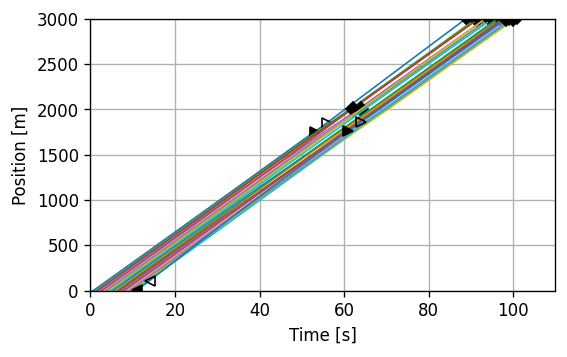

In [50]:
rec.plot('t', 'x',xmin=0, xmax=110, ymin=0, ymax=3000)

Lets zoom in in the area of the mergin lane. This will show some of the few overtaking

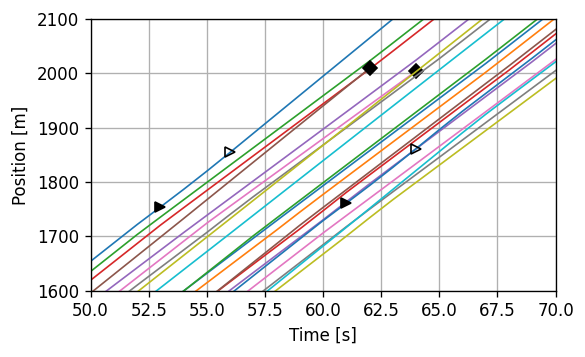

In [51]:
rec.plot('t', 'x',xmin=50, xmax=70, ymin=1600, ymax=2100)

Plot of the time and speed

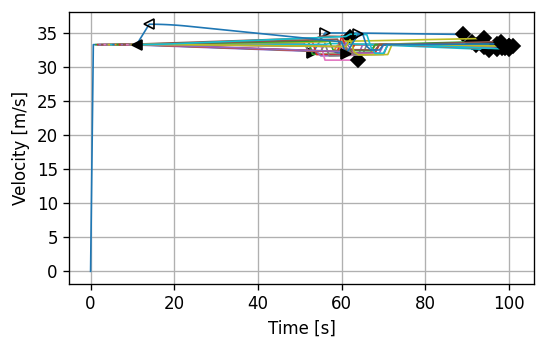

In [52]:
rec.plot('t','v')

The zoom in into the merging lane gives us a better idea of the speed changes

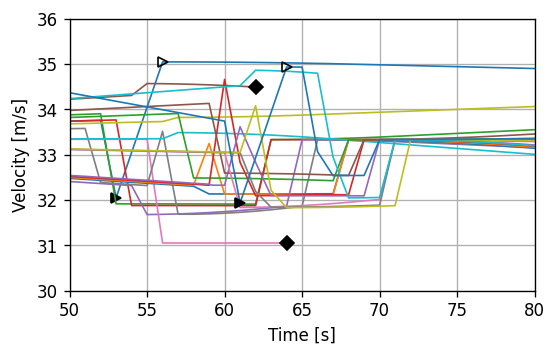

In [53]:
rec.plot('t', 'v',xmin=50, xmax=80, ymin=30, ymax=36)

Plotting the time and the acceleration shows that the most of the velocity changes happen around the 60th second, in prossimity of the merging lane

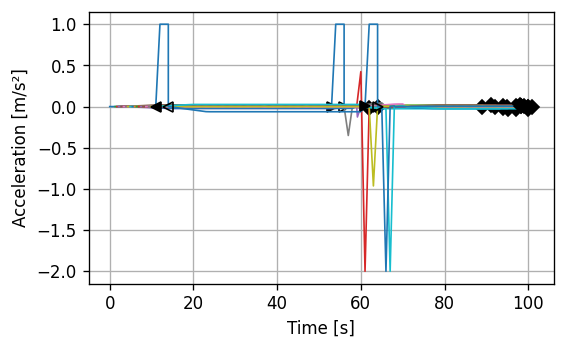

In [54]:
rec.plot('t', 'a')

The following shows that the velocity is pretty much constant along the motorway, with the exeption of the merging area. This confirms that the flow is good

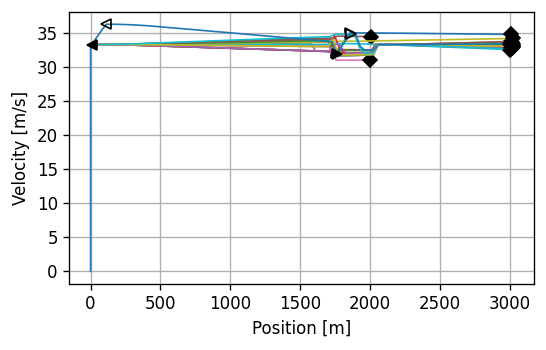

In [55]:
rec.plot('x', 'v')

Zoom in into the critical point of merging

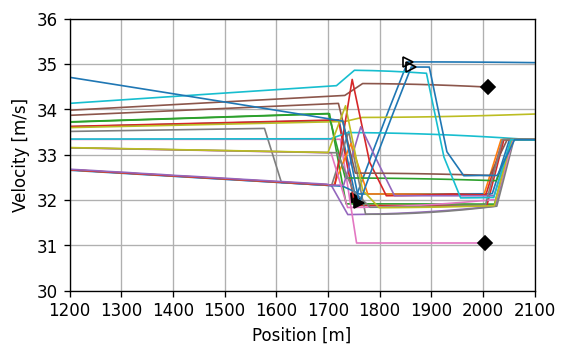

In [56]:
rec.plot('x', 'v',xmin=1200, xmax=2100, ymin=30, ymax=36)

Also plotting the acceleration over the position it can be seen that the mayor changes happen in the merging lane

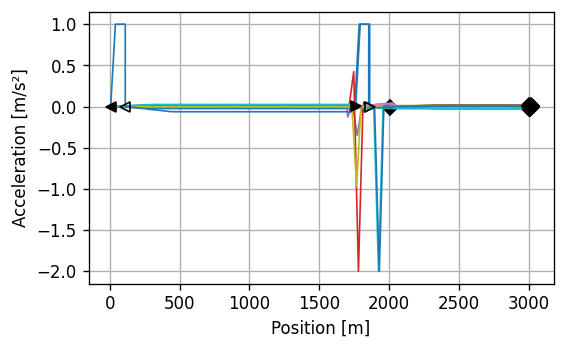

In [57]:
rec.plot('x', 'a')

Zoom in into the critical point

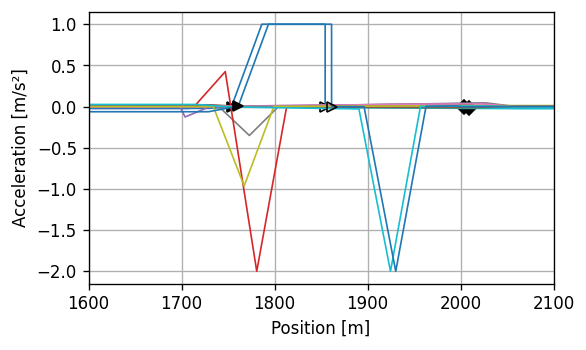

In [58]:
rec.plot('x', 'a',xmin=1600, xmax=2100)

# Frame with Traffic Density (veh/km) and Average Speed (km/h) along the lane segments

Traffic density = number of vehicles per km 

Lets take a look to the motorway again

In [59]:
rec = simulation(20, 0.52, 1, 'y')

Left Lane:   [00 x=0.0m l=1700.0m L:-- R:02]-[01 x=1700.0m l=300.0m L:-- R:03 speedLimit:120km/h]\
Centre Lane: [02 x=0.0m l=1700.0m L:00 R:05]-[03 x=1700.0m l=300.0m L:-- R:06 speedLimit:120km/h]-[04 x=2000.0m l=1000.0m L:-- R:07]
Right Lane:  [05 x=0.0m l=1700.0m L:02 R:--]-[06 x=1700.0m l=300.0m L:03 R:-- speedLimit:120km/h]-[07 x=2000.0m l=1000.0m L:04 R:--]


In [65]:
densityAndSpeed = pd.DataFrame(columns=['Lane seg', 'Dens(veh/km)', 'Av Speed(km/h)'])
for i in range(8):
    densityAndSpeed.loc[i]=(i, rec.density(i), rec.avgSpeed(i))
densityAndSpeed

,Lane seg,Dens(veh/km),Av Speed(km/h)
0,0.0,1.1809,118.95
1,1.0,0.7000,127.06
2,2.0,2.6923,119.48
3,3.0,3.3667,113.92
4,4.0,3.2800,120.12
5,5.0,2.1187,118.83
6,6.0,2.0667,117.39
7,7.0,2.1300,119.64


# Traffic Flow and Travel Times in s

In [71]:
densityAndSpeed = pd.DataFrame(columns=['Lane seg','Traf Flow(veh/h)','Average Travel time'])
for i in range(8):
    densityAndSpeed.loc[i]=(i, rec.flow(i), rec.avgTravelTime(i))
densityAndSpeed

,Lane seg,Traf Flow(veh/h),Average Travel time
0,0.0,1350.00,51.45
1,1.0,1800.00,8.50
2,2.0,3200.00,51.22
3,3.0,3333.33,9.48
4,4.0,3000.00,29.97
5,5.0,3724.14,51.50
6,6.0,3600.00,9.20
7,7.0,3600.00,30.09


In [31]:
rec.flow(0)+rec.flow(2)+rec.flow(5),   rec.flow(1)+rec.flow(3)+rec.flow(6),  rec.flow(4)+ rec.flow(7)

(8274.14, 8733.33, 6600.0)

# Traffic Flow in veh/h

The traffic flow at the exit of the motorway, in segments 4 and 7

In [32]:
rec.flow(4), rec.flow(7)

(3000.0, 3600.0)

# Traffic volume q, total number of vehicles passing per hour across all available lanes

In [33]:
totalVolume=0
for i in range(7):
    totalVolume=totalVolume+rec.flow(i)
totalVolume

20007.47

# traffic volum at the exit of the motorway 

In [34]:
volumExitMotorway= rec.flow(4)+rec.flow(7)
volumExitMotorway

6600.0

In [40]:
rec.saveData('data.csv')